# Forecasting with Chronos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-chronos.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-chronos.ipynb)


AutoGluon-TimeSeries (AG-TS) includes [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API. This tutorial describes how to 
- Use Chronos-2 in **zero-shot** mode to make forecasts without any dataset-specific training
- **Fine-tune** Chronos-2 on custom data to improve the accuracy

:::{note}

**New in v1.5:** AutoGluon now features [Chronos-2](https://arxiv.org/abs/2510.15821) — the latest version of Chronos models with _zero-shot_ support for covariates and a [90%+ win-rate](https://huggingface.co/spaces/autogluon/fev-bench) over Chronos-Bolt. The older version of this tutorial with the Chronos-Bolt model is available [here](https://auto.gluon.ai/1.4.0/tutorials/timeseries/forecasting-chronos.html).

:::

In [ ]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS. 
Specifically, by default, Chronos models do not really `fit` time series data. However, when `predict` is called, they perform _zero-shot inference_ by using the provided contextual information. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference. 

AutoGluon supports the original Chronos models (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), the Chronos-Bolt models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)), and the latest Chronos-2 models (e.g., [`chronos-2`](https://huggingface.co/autogluon/chronos-2)). The following table compares the capabilities of the three model families.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |
| Max. Prediction Length | 64 | 64 | 1024 |


The easiest way to get started with Chronos is through the model-specific presets. 

- **(recommended)** The Chronos-2 models can be accessed using the `"chronos2_small"` and `"chronos2"` presets.
- The Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.
- The original Chronos models can be accessed using the `"chronos_tiny"`, `"chronos_mini"`, `"chronos_small"`, `"chronos_base"` and `"chronos_large"` presets.

Alternatively, Chronos can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

Note that the original Chronos models of size `small` and above require a GPU to run, while all Chronos-Bolt and Chronos-2 models can be run both on a CPU and a GPU. When fine-tuning the models, we recommend using a GPU for faster training times. 


🧩 Chronos/Chronos-Bolt do not natively support future covariates, but they can be combined with external covariate regressors (see [AutoGluon tutorial](https://auto.gluon.ai/1.4.0/tutorials/timeseries/forecasting-chronos.html#incorporating-the-covariates)). This only models per-timestep effects, not effects across time. In contrast, Chronos-2 supports all covariate types natively.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Zero-shot forecasting

### Univariate Forecasting

Let's work with a subset of the [Australian Electricity Demand dataset](https://zenodo.org/records/4659727) to see Chronos-2 in action.

First, we load the dataset as a [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html).

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [3]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
)
data.head()

target
item_id timestamp                       
T000000 2013-03-10 00:00:00  5207.959961
        2013-03-10 00:30:00  5002.275879
        2013-03-10 01:00:00  4747.569824
        2013-03-10 01:30:00  4544.880859
        2013-03-10 02:00:00  4425.952148

Next, we create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"chronos2"` presets to use the Chronos-2 (120M) model in zero-shot mode.

In [4]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos2",
)

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to '/fsx/ansarnd/repos/autogluon/docs/tutorials/timeseries/AutogluonModels/ag-20251212_155203'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250910
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP Fri Aug 22 15:44:33 UTC 2025
CPU Count:          96
Pytorch Version:    2.7.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 39.38/39.38 GB
Total GPU Memory:   Free: 39.38 GB, Allocated: 0.00 GB, Total: 39.38 GB
GPU Count:          1
Memory Avail:       1037.30 GB / 1121.80 GB (92.5%)
Disk Space Avail:   1764.67 GB / 11459.15 GB (15.4%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_wi

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk. 

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos2


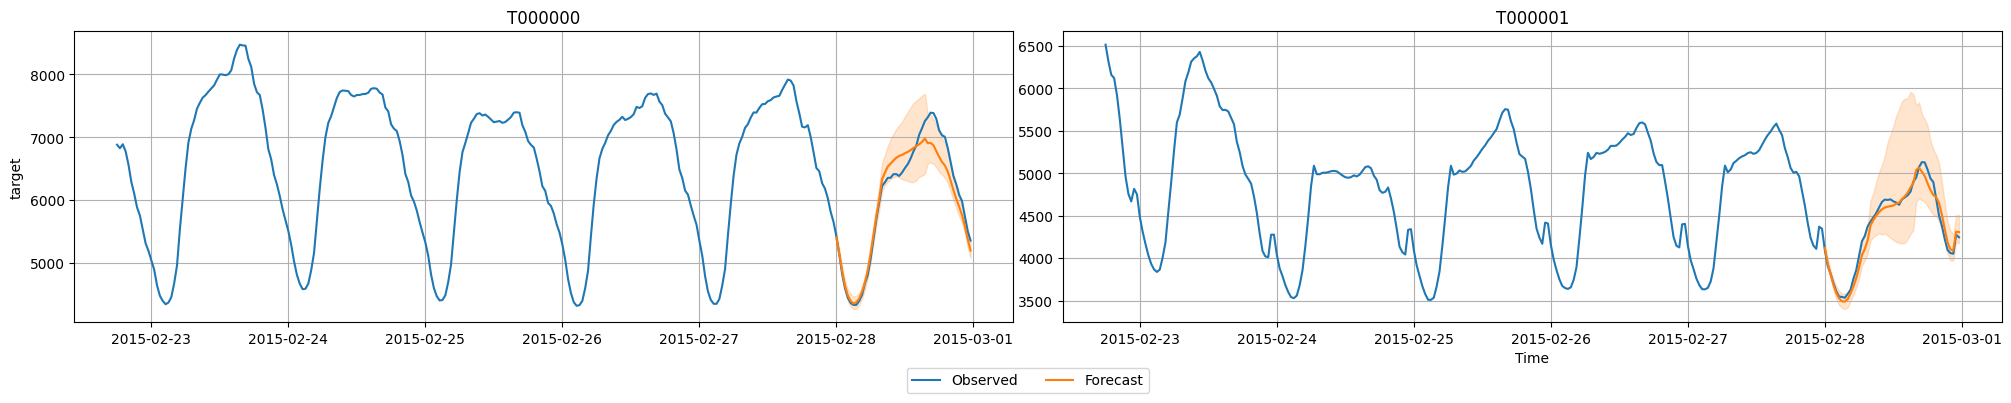

In [5]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=300,
);

## Forecasting with covariates

The previous example showed Chronos-2 in action on a univariate forecasting task, i.e., only the historical data of the target time series for making predictions. However, in real-world scenarios, additional exogenous information related to the target series (e.g., weather forecasts, holidays, promotions) is often available. These exogenous time series, often referred to as covariates, may either be observed only in the past (past-only) or also in the forecast horizon (known future). Leveraging this information when making predictions can improve forecast accuracy. 

Chronos-2 natively supports (dynamic) covariates, past-only and known-future, real-valued or categorical. Let's see how we can use Chronos-2 to forecast with covariates on a **Electrical Load Forecasting** task.

In [6]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/bull/test.parquet", id_column="id"
)
data.head()

load  airtemperature  \
item_id                timestamp                                     
Bull_education_Magaret 2016-01-01 00:00:00  0.0000             9.4   
                       2016-01-01 01:00:00  2.7908             8.9   
                       2016-01-01 02:00:00  3.7210             8.9   
                       2016-01-01 03:00:00  2.7908             8.3   
                       2016-01-01 04:00:00  9.3025             7.8   

                                            dewtemperature  sealvlpressure  
item_id                timestamp                                            
Bull_education_Magaret 2016-01-01 00:00:00             3.3     1028.699951  
                       2016-01-01 01:00:00             2.2     1028.800049  
                       2016-01-01 02:00:00             2.2     1029.599976  
                       2016-01-01 03:00:00             1.7     1029.500000  
                       2016-01-01 04:00:00             1.7     1029.599976

The goal is to forecast next day's (24 hours) load using historical load and known weather covariates: air temperature, dew temperature and sea level pressure. Since future weather information is not known in advance, weather forecasts are typically used as known covariates.

In [7]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

Sorting the dataframe index before generating the train/test split.


The following code uses Chronos-2 in the TimeSeriesPredictor to forecast the `load` for the next 24 hours. We use the _univariate_ [Chronos-Bolt (Small)](https://huggingface.co/autogluon/chronos-bolt-small) model as a baseline for comparison.

Note that we have specified the target column we are interested in forecasting and the names of known covariates while constructing the TimeSeriesPredictor. Any other columns, if present, will be used as past-only covariates.

In [8]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="load",
    known_covariates_names=["airtemperature", "dewtemperature", "sealvlpressure"],
    eval_metric="MASE",
).fit(
    train_data,
    hyperparameters={"Chronos": {}, "Chronos2": {}},
    enable_ensemble=False,
    time_limit=60,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/fsx/ansarnd/repos/autogluon/docs/tutorials/timeseries/AutogluonModels/ag-20251212_155218'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250910
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP Fri Aug 22 15:44:33 UTC 2025
CPU Count:          96
Pytorch Version:    2.7.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 39.37/39.38 GB
Total GPU Memory:   Free: 39.37 GB, Allocated: 0.01 GB, Total: 39.38 GB
GPU Count:          1
Memory Avail:       1036.22 GB / 1121.80 GB (92.4%)
Disk Space Avail:   1764.67 GB / 11459.15 GB (15.4%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {}, 'Chronos2': {}},
 'known_covariates_names': ['airtemperature',
                            'dewtemperature',
                            'sealvlpressure'],
 '

Once the predictor has been fit, we can evaluate it on the test dataset and generate the leaderboard. We see that Chronos-2, which utilizes covariates, produces a significantly more accurate forecast on the test set compared to Chronos-Bolt, which being a univariate model does not utilize covariates.

In [9]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos2,-0.696239,-0.817203,2.262356,1.604926,0.750669,2
1,Chronos[autogluon__chronos-bolt-small],-1.278404,-1.086471,0.582970,0.584009,1.257359,1


We can also use the predictor to compute features importances to understand which exogenous features are affecting the prediction the most.

In [10]:
predictor.feature_importance(test_data, model="Chronos2", relative_scores=True)

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


,importance,stdev,n,p99_low,p99_high
airtemperature,0.324309,0.0,5.0,0.324309,0.324309
dewtemperature,0.057110,0.0,5.0,0.057110,0.057110
sealvlpressure,0.038278,0.0,5.0,0.038278,0.038278


In this example, the `airtemperature` feature is the most important for accurate forecasting.

Note that the covariates may not always be useful and using more covariates does not necessarily imply more accurate forecasts. With Chronos-2, AutoGluon makes it easy for users to quickly validate different configurations and find ones that perform best on held-out data. 

## Fine-tuning 

We have seen above how Chronos-2 models can produce forecasts in zero-shot mode, both with and without covariates. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

The following snippet specifies two settings for the Chronos-2 model: zero-shot and fine-tuned. `TimeSeriesPredictor` will perform a lightweight fine-tuning of the pretrained model on the provided training data. We add name suffixes to easily identify the zero-shot and fine-tuned versions of the model.

In [11]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="load",
    known_covariates_names=["airtemperature", "dewtemperature", "sealvlpressure"],
    eval_metric="MASE",
).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos2": [
            {"ag_args": {"name_suffix": "ZeroShot"}},
            {"fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=300,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to '/fsx/ansarnd/repos/autogluon/docs/tutorials/timeseries/AutogluonModels/ag-20251212_155303'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250910
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP Fri Aug 22 15:44:33 UTC 2025
CPU Count:          96
Pytorch Version:    2.7.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 39.37/39.38 GB
Total GPU Memory:   Free: 39.37 GB, Allocated: 0.01 GB, Total: 39.38 GB
GPU Count:          1
Memory Avail:       1036.08 GB / 1121.80 GB (92.4%)
Disk Space Avail:   1764.65 GB / 11459.14 GB (15.4%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos2': [{'ag_args': {'name_suffix': 'ZeroShot'}},
                                  {'ag_args': {'name_suffix': 'FineTuned'},
                                   'fine_

Here we used the default fine-tuning configuration for Chronos-2 by only specifying `"fine_tune": True`. By default, Chronos-2 is fine-tuned with a low-rank adapter (LoRA) to reduce memory and disk footprint. AutoGluon makes it easy to change other parameters for fine-tuning such as the fine-tuning mode, number of steps or learning rate.
```python
predictor.fit(
    ...,
    hyperparameters={"Chronos2": {"fine_tune": True, "fine_tune_mode": "full", "fine_tune_lr": 1e-4, "fine_tune_steps": 2000, "fine_tune_batch_size": 32}},
)
```

For the full list of fine-tuning options, see the Chronos-2 documentation in [Forecasting Model Zoo](forecasting-model-zoo.md#autogluon.timeseries.models.Chronos2Model).


After fitting, we can evaluate the two model variants on the test data and generate a leaderboard.

In [12]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos2FineTuned,-0.677943,-0.803210,2.586170,0.762990,123.312997,2
1,Chronos2ZeroShot,-0.696239,-0.817203,2.262884,1.600218,0.907641,1


Fine-tuning resulted in a more accurate model, as shown by the better `score_test` on the test set.

Note that all AutoGluon-TimeSeries models report scores in a "higher is better" format, meaning that most forecasting error metrics like MASE are multiplied by -1 when reported.

## FAQ


#### How accurate is Chronos-2?

Chronos-2 is the best (last updated: Dec 2025) performing time series foundation model across multiple benchmarks such as [fev-bench](https://huggingface.co/spaces/autogluon/fev-bench), [GIFT-Eval](https://huggingface.co/spaces/Salesforce/GIFT-Eval) and [Chronos Bench II](https://arxiv.org/abs/2403.07815). Details empirical results can be found in the [Chronos-2 technical report](https://arxiv.org/abs/2510.15821). The accuracy of Chronos-2 often exceeds statistical baseline models and task-specific deep learning models such as `DeepAR` and `TemporalFusionTransformer`.

#### What is the recommended hardware for running Chronos models?

We recommned using a machine with GPU for the best performance, especially when fine-tuning the models. However, Chronos-2, Chronos-Bolt and Chronos (up to small size) can also be used on CPU machines with reasonable inference times. For reference, we tested the models on AWS `g5.2xlarge` instances that feature NVIDIA A10G GPUs with at least 24GiB of GPU memory and 32GiB of main memory. 

#### Why do my predictions change with the `batch_size`?

By default, AutoGluon enables the `cross_learning` mode of Chronos-2. This means that the model makes joint predictions across time series in a batch which often improves forecast accuracy but also makes the results sensitive to the `batch_size`. You can disable this mode using:

```python
predictor.fit(
    ...,
    hyperparameters={"Chronos2": {"cross_learning": False}},
)
```

#### Where can I ask specific questions on Chronos?

The AutoGluon team are among the core developers of Chronos. So you can ask Chronos-related questions on AutoGluon channels such 
as the Discord [server](https://discord.gg/wjUmjqAc2N), or [GitHub](https://github.com/autogluon/autogluon). You can also join 
the discussion on the Chronos GitHub [page](https://github.com/amazon-science/chronos-forecasting/discussions).